In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [ ]:
# !pip install seaborn

In [227]:
def pd_xand(a, b):
    return (a & b) | (~a & ~b)
    
def score_calibration(df):
    # margin is score diff
    df["margin"] = df["scores"] - df["reference_scores"]

    # our negative range doesn't seem to go as low as positive goes high
    # maybe we should cut off our max margin at 99.5% quantile
    margin_max = df['margin'].quantile(0.995) 
    # margin_max = df['margin'].max()
    margin_max_rounded = np.round(margin_max * 2) / 2
    # print(type(margin_upper))
    print(f"high {margin_max_rounded}")
    interval_tuples = [(i, i+0.5) for i in np.arange(0, margin_max_rounded, 0.5)]
    bins = pd.IntervalIndex.from_tuples(interval_tuples)
    df['margin_bins'] = pd.cut(df['margin'].abs(), bins)
    df['accuracy'] = pd_xand((df["preferred"] == "ours"), (df["margin"] > 0)).astype(float)

    margin_df = df.groupby('margin_bins')['accuracy'].mean()
    margin_df = margin_df.reset_index()
    margin_df["middle"] = margin_df['margin_bins'].apply(lambda x: x.mid)

    return margin_df

def score_calibration_reward_eval(df):
    # margin is score diff
    df["margin"] = df["chosen_rewards"] - df["rejected_rewards"]

    # our negative range doesn't seem to go as low as positive goes high
    # maybe we should cut off our max margin at 99.5% quantile
    margin_max = df['margin'].quantile(0.995) 
    # margin_max = df['margin'].max()
    margin_max_rounded = np.round(margin_max * 2) / 2
    # print(type(margin_upper))
    print(f"high {margin_max_rounded}")
    interval_tuples = [(i, i+0.5) for i in np.arange(0, margin_max_rounded, 0.5)]
    bins = pd.IntervalIndex.from_tuples(interval_tuples)
    df['margin_bins'] = pd.cut(df['margin'].abs(), bins)
    # df['accuracy'] = pd_xand((df["preferred"] == "ours"), (df["margin"] > 0)).astype(float)
    df["accuracy"] = df["accuracy"].astype(float)
    
    margin_df = df.groupby('margin_bins')['accuracy'].mean()
    margin_df = margin_df.reset_index()
    margin_df["middle"] = margin_df['margin_bins'].apply(lambda x: x.mid)

    return margin_df

high 7.5
high 8.5
high 7.5
high 8.0
high 8.0
high 8.0
high 8.0
high 8.0
high 8.0
high 8.5


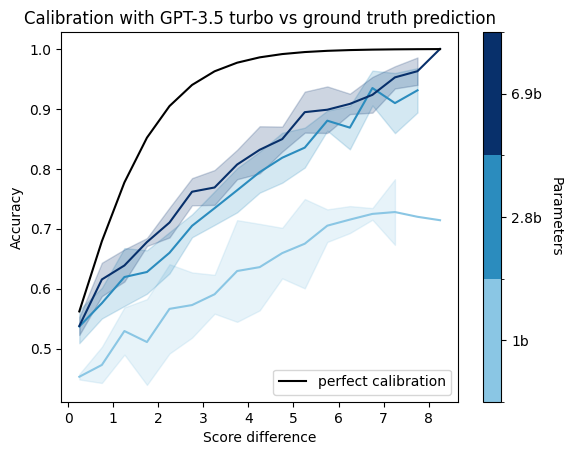

In [248]:
models = [
    "EleutherAI/pythia-1b-deduped",
    "EleutherAI/pythia-2.8b-deduped",
    "EleutherAI/pythia-6.9b-deduped",
]
colors = ['#8ac6e4', '#2b8cbe', '#08306b']
SEEDS = [44413, 55513, 66613, 77713]

for model, color in zip(models, colors):
    margin_dfs = []
    for seed in SEEDS:
        if model == "EleutherAI/pythia-1b-deduped" and seed not in [55513,77713]:
            continue
        eval_fname = f"eval/sampled_data/refactor-chosen-rejected3/ppo_left_padding/{model}/{seed}/query_responses_gpt-3.5-turbo-0125.csv"
        margin_dfs.append(score_calibration(pd.read_csv(eval_fname)))
    sns.lineplot(data=pd.concat(margin_dfs).reset_index(), x="middle", y="accuracy", estimator="mean", errorbar="sd", color=color)

perfect_calibration = margin_dfs[-1]["middle"].apply(lambda x: 1 / (1 + math.exp(-x)))
sns.lineplot(x=margin_dfs[-1]["middle"], y=perfect_calibration, color="black", label="perfect calibration")

plt.title("Calibration with GPT-3.5 turbo vs ground truth prediction")
plt.xlabel("Score difference")
plt.ylabel("Accuracy")
plt.gca().invert_yaxis()

cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[0, 1, 2, 3], ncolors=4)  # Adjust boundaries to match the number of colors
cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical')
cb.set_ticks([0.5, 1.5, 2.5])
cb.set_ticklabels(['1b', '2.8b', '6.9b'])
cb.set_label('Parameters', rotation=270, labelpad=15)
plt.legend(loc='lower right')

high 5.5
high 5.0
high 5.5
high 5.5
high 6.0
high 6.0
high 6.0
high 6.5
high 6.5
high 6.5
high 7.0


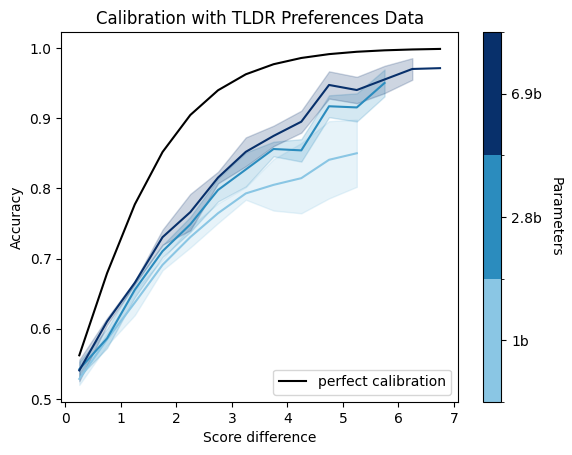

In [246]:
import matplotlib.cm as cm

models = [
    "EleutherAI/pythia-1b-deduped",
    "EleutherAI/pythia-2.8b-deduped",
    "EleutherAI/pythia-6.9b-deduped",
]
colors = ['#8ac6e4', '#2b8cbe', '#08306b']
SEEDS = [44413, 55513, 66613, 77713]

for model, color in zip(models, colors):
    margin_dfs = []
    for seed in SEEDS:
        if model == "EleutherAI/pythia-2.8b-deduped" and seed in [44413]:
            continue
        eval_fname = f"eval/sampled_data/refactor-chosen-rejected3/reward_eval/{model}/{seed}/query_responses.csv"
        margin_dfs.append(score_calibration_reward_eval(pd.read_csv(eval_fname)))
    sns.lineplot(data=pd.concat(margin_dfs).reset_index(), x="middle", y="accuracy", estimator="mean", errorbar="sd", color=color)

perfect_calibration = margin_dfs[-1]["middle"].apply(lambda x: 1 / (1 + math.exp(-x)))
sns.lineplot(x=margin_dfs[-1]["middle"], y=perfect_calibration, color="black", label="perfect calibration")

plt.title("Calibration with TLDR Preferences Data")
plt.xlabel("Score difference")
plt.ylabel("Accuracy")
# plt.legend()
plt.gca().invert_yaxis()

cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[0, 1, 2, 3], ncolors=4)  # Adjust boundaries to match the number of colors
cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical')
cb.set_ticks([0.5, 1.5, 2.5])
cb.set_ticklabels(['1b', '2.8b', '6.9b'])
cb.set_label('Parameters', rotation=270, labelpad=15)
plt.legend(loc='lower right')